# Audio Classification Example

Calculating spectrogram

In [1]:
import audio
wav_file = 'EPIC_KITCHENS_2018/action/audio/train/P01/P01_01_90_close-tap.wav'
spectrogram = audio.extract_spectrogram(wav_file, window_size=0.03, window_stride=0.015, n_fft=661)

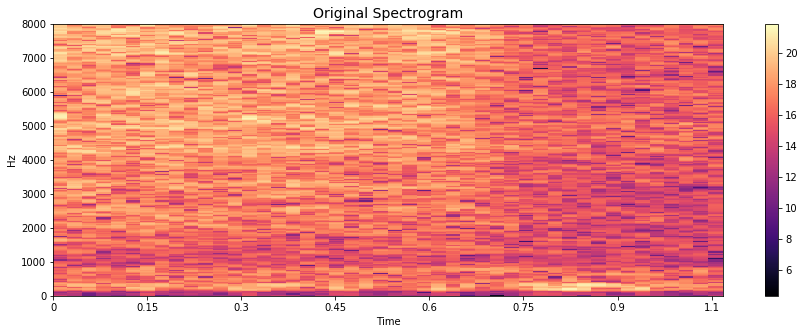

In [2]:
import librosa
import librosa.display
from matplotlib import pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(15, 5))
plt.clf()
ax = fig.add_subplot(111)
x, sr = librosa.load(wav_file)
librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='hz')
plt.ylim(0,8000)
plt.colorbar()
ax.set_title('Original Spectrogram', fontsize=14)
plt.show()

Loading normalization data

In [3]:
from addict import Dict as adict
import json

spectrogram_stats_fpath = 'EPIC_KITCHENS_2018/action/audio/train/spectrograms_stats.json'
with open(spectrogram_stats_fpath) as json_file:
    stats = adict(json.load(json_file))
std_min = (stats.min - stats.mean) / stats.std_dev
std_max = (stats.max - stats.mean) / stats.std_dev

Normalizing spectrogram

In [4]:
# Standardization
std_spectrogram = (spectrogram - stats.mean) / stats.std_dev
# Normalization
norm_spectrogram = (std_spectrogram - std_min) / (std_max - std_min)

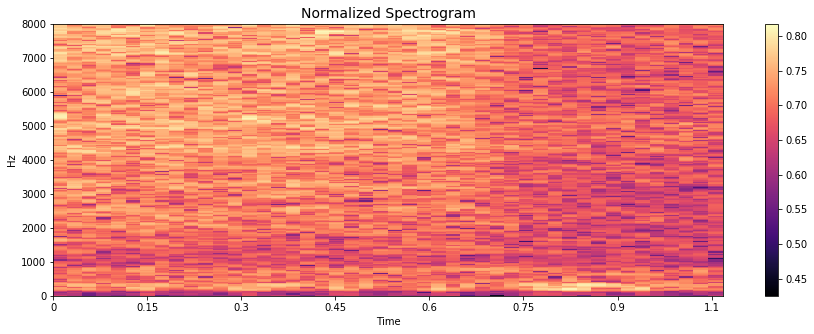

In [5]:
fig = plt.figure(figsize=(15, 5))
plt.clf()
ax = fig.add_subplot(111)
x, sr = librosa.load(wav_file)
librosa.display.specshow(norm_spectrogram, sr=sr, x_axis='time', y_axis='hz')
plt.ylim(0,8000)
plt.colorbar()
ax.set_title('Normalized Spectrogram', fontsize=14)
plt.show()

Splitting the spectrogram into frames of $331\times248$

In [6]:
num_secs=4
frames, last_idx = audio.to_frames(norm_spectrogram, 62 * num_secs)
frame = frames[0]

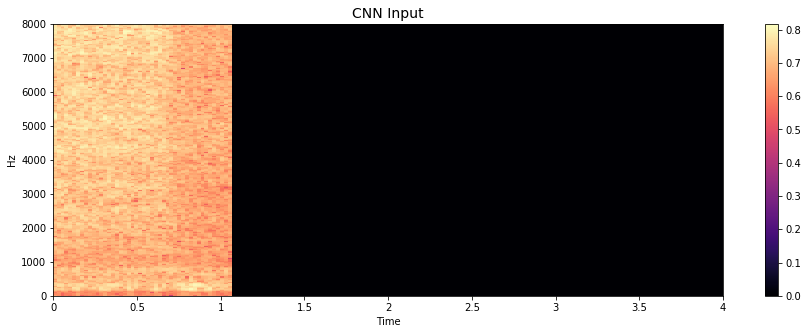

In [7]:
fig = plt.figure(figsize=(15, 5))
plt.clf()
ax = fig.add_subplot(111)

librosa.display.specshow(frame, sr=sr, x_axis='time', y_axis='hz')
plt.ylim(0,8000)
plt.xlim(0,4)
plt.colorbar()
ax.set_title('CNN Input', fontsize=14)
plt.show()

Loading audio verb configuration

In [8]:
audio_verb_conf = 'conf/audio_verb_args.json'
with open(audio_verb_conf) as json_file:
    conf = adict(json.load(json_file))

In [9]:
import torch
import torch.nn.parallel
import torchvision.transforms as transforms
from IO.misc import ToFloatTensor

conf.cuda = conf.cuda and torch.cuda.is_available()
torch.manual_seed(conf.seed)
if conf.cuda:
    torch.cuda.manual_seed(conf.seed)
    print('Using CUDA with {0} GPUs'.format(torch.cuda.device_count()))
print(conf)

Using CUDA with 4 GPUs
{'audio_hdf5': 'EPIC_KITCHENS_2018/action/audio/train/audio_dataset_norm_4secs.hdf5', 'classes_map': 'annotations/EPIC_ARC_verb_classes_map.pkl', 'type': 'verb', 'splits': 'annotations/EPIC_ARC_verb_splits.pkl', 'train': False, 'test_epoch': 79, 'arc': 'VGG11', 'optimizer': 'SGD', 'lr': 5e-06, 'momentum': 0.9, 'epochs': 100, 'batch_size': 6, 'test_batch_size': 1, 'log_interval': 100, 'patience': 80, 'num_workers': 1, 'cuda': True, 'checkpoint': 'checkpoint', 'seed': 42, 'weights_file': None, 'challenge_test_sets': [{'name': 's1', 'audio_hdf5': 'EPIC_KITCHENS_2018/action/audio/test/audio_test_s1_norm_4secs.hdf5'}, {'name': 's2', 'audio_hdf5': 'EPIC_KITCHENS_2018/action/audio/test/audio_test_s2_norm_4secs.hdf5'}]}


In [10]:
state = torch.load('./{}/audio_{}_{}_lr_{}_ckpt.t7'.format(conf.checkpoint, conf.type, conf.arc, conf.lr))
epoch = conf.test_epoch if conf.test_epoch else state['epoch']

model = torch.load(
'./{}/audio_{}_{}_lr_{}_model_{:03d}.t7'.format(conf.checkpoint, conf.type, conf.arc, conf.lr, epoch))
if conf.cuda:
    model = torch.nn.DataParallel(model).cuda()

In [27]:
from torch.autograd import Variable
import numpy as np
import sys
transform = transforms.Compose([ToFloatTensor()])

data = transform(frame[np.newaxis,:])
data = data.cuda()
data = Variable(data, volatile=True)
scores = model(data)
scores = scores.data.cpu().numpy()
category_id = (np.argmax(scores))

/home/b.aca/b.aca/anaconda3/envs/epic_torch_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


In [41]:
import pickle
from IO import EpicClass


verbs_map = pickle.load(open(conf.classes_map, "rb"))
verbs = EpicClass.load_from('annotations/EPIC_verb_classes.csv')

category = verbs[verbs_map[category_id]].name
print(category)

shake
